Usando la definición de Wikipedia de TSP: 

The travelling salesman problem (also called the travelling salesperson problem or TSP) asks the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?" It is an NP-hard problem in combinatorial optimization, important in theoretical computer science and operations research.

https://en.wikipedia.org/wiki/Travelling_salesman_problem

## Generación del conjunto de datos:

### Generación de un grafo aleatorio

En primer lugar, utilizando el móludo de gestión deinámica de estructuras `networkx`, se genera un grafo ponderado de forma aleatoria mediante la función definida a continuación:

In [1]:
import networkx as nx
import random
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programming

def generate_random_tsp_graph(n_cities, min_distance=1, max_distance=100):
    G = nx.Graph()
    for i in range(n_cities):
        G.add_node(i)

    for i in range(n_cities):
        for j in range(i+1, n_cities):
            distance = random.randint(min_distance, max_distance)
            G.add_edge(i, j, weight=distance)

    return G

Se hace uso del popular módulo `matplotlib` para visualización de datos a la hora de mostrar el grafo completo ponderado de 10 nodos:

In [2]:
import matplotlib.pyplot as plt
def draw_tsp_graph(G, path=None):
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    if path:
        edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='r', width=2)

    plt.show()

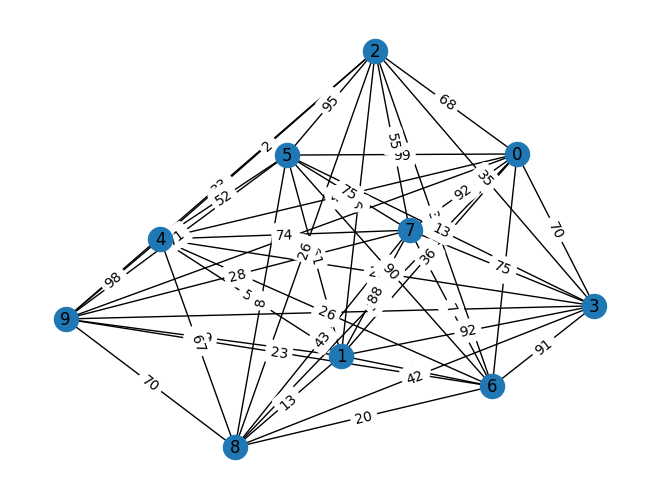

In [3]:
G = generate_random_tsp_graph(10)
draw_tsp_graph(G)

Se emplea la siguiente función para transformar un grafo del módulo `networkx` a una lista de adyacencia implementada con listas nativas de python:

In [4]:
def graph_to_adjacency_matrix(G):
    return nx.adjacency_matrix(G).todense().tolist()

## Resolución del camino de coste mínimo entre 2 nodos del grafo

A continuación se genera y visualiza de nuevo un grafo aleatorio, esta vez resaltando sobre él el camino hamiltoniano que minimiza el peso.

/tmp/ipykernel_964/1960871929.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(G).todense().tolist()


Optimal path: [0, 13, 11, 6, 3, 8, 2, 1, 7, 9, 5, 4, 12, 10, 14]
Optimal cost: 190


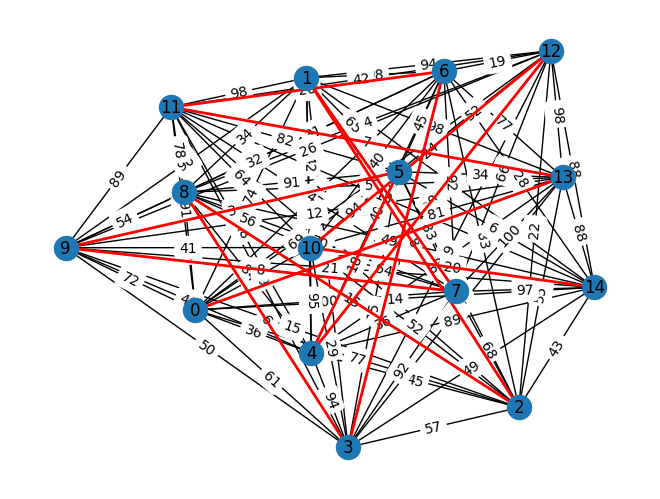

In [5]:
# Find the optimal path and cost
n_nodes = 15
min_weight = 1
max_weight = 100
random_graph = generate_random_tsp_graph(n_nodes, min_weight, max_weight)
ad_matrix = np.array(graph_to_adjacency_matrix(random_graph))
permutation, distance = solve_tsp_dynamic_programming(ad_matrix)

print(f"Optimal path: {permutation}")
print(f"Optimal cost: {distance}")
draw_tsp_graph(random_graph, path=permutation)

Ahora que es posible determinar caminos de coste mínimo sobre un grafo, utilizamos las funciones anteriores para crear ejemplos del dataset, cada uno de ellos en el siguiente formato: `(matriz de adyacencia de G, ruta óptima a través de G)`.

Se hace uso de Dataframes de `pandas` para generar estos datos y almacenarlos en un archivo en formato csv. Este fichero recibe el nombre de `dataset_raw.csv` ya que no se preprocesan los datos de ninguna manera.  
Por otro lado, es conveniente conservar el dataset original para poder aplicar distintas transformaciones y preprocesados sin perder acceso a los datos en su forma original.

In [ ]:
import pandas as pd

n_nodes = 15
min_weight = 1
max_weight = 100
example_number = 1_000

def generate_dataset(filename: str, n_nodes: int, min_weight: int, max_weight: int, example_number: int):
    graphs = []
    routes = []

    for i in range(example_number):
        random_graph = generate_random_tsp_graph(n_nodes, min_weight, max_weight)
        ad_matrix = np.array(graph_to_adjacency_matrix(random_graph))

        permutation, distance = solve_tsp_dynamic_programming(ad_matrix)
        
        graphs.append(ad_matrix)
        routes.append(np.array(permutation))

        if i % 10 == 0:
            print(f'Graphs: {i}/{example_number}')
    data = {'graph': graphs, 'route': routes}
    df = pd.DataFrame(data)

    df.to_csv(filename, index=False)

    return df

generate_dataset('dataset_raw_stock.csv', n_nodes, min_weight, max_weight, example_number)

## Preparación de los datos

Para muchos de los algoritmos que se evaluarán es conveniente dividir los ejemplos de entrenamiento en múltiples problemas de clasificación individuales.  
Dividiendo cada ejemplo de predicción de un camino hamiltoniano en varios ejemplos de clasificación del siguiente nodo en el camino hamiltoniano podemos simplificar la arquitectura del algoritmo.

Para dividir cada ejemplo de entrenamiento se procesarán los datos de la siguiente manera:  
1. Se toma el ejemplo en forma:  
Predictores: **Grafo**, Etiqueta: **camino hamiltoniano** [a, b, c, d, e, f, g, h, i]  

2. Se divide en 9 ejemplos de clasificación en el siguiente formato:  
Predictores: **Grafo, camino actual** Etiqueta: **siguiente nodo**  
Ejemplo: **Grafo**: [Matriz de adyancencia], **camino actual**: [h, a, d], **siguiente nodo**: "f"  

3. Se hace padding con el valor -1, que no corresponde a ninguna clase, para que las entradas tengan longitud consistente:  
Ejemplo: **Grafo**: [Matriz de adyancencia], **camino actual**: [h, a, d, -1, -1, -1, -1, -1, -1], **siguiente nodo**: "f"

En primer lugar, se leen los conjuntos de entrenamiento y test a Dataframes de pandas.

In [6]:
import pandas as pd

In [7]:
df_raw = pd.read_csv('dataset_raw_stock.csv')

A continuación, se procede a los pasos del preprocesado en el orden mencionado anteriormente:

### Pasos 1 y 2: Lectura de los  datos, ampliación de los ejemplos:

In [8]:
# Initialize an empty dataframe for the new dataset
new_data = pd.DataFrame(columns=['graph', 'current_path', 'next_node'])

# Process each row in the input dataset
for index, row in df_raw.iterrows():
    # Parse the graph and the original route
    graph = row['graph']
    lines = graph.split("\n")
    parsed_matrix = []
    for line in lines:
        # Remove the brackets and split by spaces
        splitted = line.replace("[", "").replace("]", "").split()
        # Convert the splitted items to integers
        parsed_row = [int(item) for item in splitted if item]
        parsed_matrix.append(parsed_row)

    route = row['route']
    splitted = route.replace("[", "").replace("]", "").split()
    parsed_list = [int(item) for item in splitted if item]

    route = parsed_list
    
    graph = parsed_matrix

    # Create new examples from the original route
    for i in range(len(route) - 1):
        current_path = route[:i + 1]
        next_node = route[i + 1]
        
        # Append the new example to the new dataset
        new_row = pd.DataFrame([{'graph': graph, 'current_path': current_path, 'next_node': next_node}])
        new_data = pd.concat([new_data, new_row], axis=0, ignore_index=True)

df = new_data

A continuación vemos como a partir de cada ejemplo del conjunto de entrenamiento, hemos creado 9 ejemplos en el conjunto de entrenamiento preprocesado:

In [9]:
df

,graph,current_path,next_node
0,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...",[0],12
1,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12]",4
2,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, 4]",9
3,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, 4, 9]",14
4,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, 4, 9, 14]",3
...,...,...,...
13995,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13]",3
13996,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, 3]",7
13997,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, 3, 7]",14
13998,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, 3, 7, 14]",8


### Paso 3: Se aplica padding con el valor -1:

In [10]:
n_nodes = 15
df['current_path'] = df['current_path'].apply(lambda x: x + [-1] * (n_nodes - 1 - len(x)))
df

,graph,current_path,next_node
0,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...",12
1,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...",4
2,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",9
3,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, 4, 9, -1, -1, -1, -1, -1, -1, -1, -1, ...",14
4,"[[0, 91, 59, 28, 83, 40, 15, 51, 90, 64, 100, ...","[0, 12, 4, 9, 14, -1, -1, -1, -1, -1, -1, -1, ...",3
...,...,...,...
13995,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, -1, -1, -1, -1]",3
13996,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, 3, -1, -1, -1]",7
13997,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, 3, 7, -1, -1]",14
13998,"[[0, 78, 17, 94, 52, 68, 55, 99, 70, 48, 3, 11...","[0, 2, 10, 5, 12, 9, 6, 1, 4, 13, 3, 7, 14, -1]",8


Se separan las secuencias de nodos (caminos parciales) en varias columnas una vez todas miden lo mismo:

In [11]:
# Expand sequence_of_nodes
expanded_df = df['current_path'].apply(lambda x: pd.Series(x))
expanded_df.columns = [f'seq_{i}' for i in range(1, n_nodes)]

df = df.drop('current_path', axis=1)
df = pd.concat([df, expanded_df], axis=1)

Podemos ver que cada secuencia de nodos original ha sido transformada en 9 columnas que forman parte de la secuencia:

In [12]:
df.drop('graph', axis=1)

,next_node,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,seq_7,seq_8,seq_9,seq_10,seq_11,seq_12,seq_13,seq_14
0,12,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,4,0,12,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,9,0,12,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,14,0,12,4,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,3,0,12,4,9,14,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,3,0,2,10,5,12,9,6,1,4,13,-1,-1,-1,-1
13996,7,0,2,10,5,12,9,6,1,4,13,3,-1,-1,-1
13997,14,0,2,10,5,12,9,6,1,4,13,3,7,-1,-1
13998,8,0,2,10,5,12,9,6,1,4,13,3,7,14,-1


Se aplanan las listas de adyacencia (listas de listas) en una lista de elementos monodimensional.

In [14]:
# Expand adjacency_matrix
df['flat_list'] = df['graph'].apply(lambda x: [item for sublist in x for item in sublist])
expanded_df = df['flat_list'].apply(lambda x: pd.Series(x))
expanded_df.columns = [f'col_{i}' for i in range(1, n_nodes**2 + 1)]

df = df.drop('flat_list', axis=1)
df = df.drop('graph', axis=1)
df = pd.concat([df, expanded_df], axis=1)

In [15]:
df

,next_node,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,seq_7,seq_8,seq_9,...,col_216,col_217,col_218,col_219,col_220,col_221,col_222,col_223,col_224,col_225
0,12,0,-1,-1,-1,-1,-1,-1,-1,-1,...,33,49,79,54,20,1,72,40,91,0
1,4,0,12,-1,-1,-1,-1,-1,-1,-1,...,33,49,79,54,20,1,72,40,91,0
2,9,0,12,4,-1,-1,-1,-1,-1,-1,...,33,49,79,54,20,1,72,40,91,0
3,14,0,12,4,9,-1,-1,-1,-1,-1,...,33,49,79,54,20,1,72,40,91,0
4,3,0,12,4,9,14,-1,-1,-1,-1,...,33,49,79,54,20,1,72,40,91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,3,0,2,10,5,12,9,6,1,4,...,79,69,1,28,89,14,79,89,94,0
13996,7,0,2,10,5,12,9,6,1,4,...,79,69,1,28,89,14,79,89,94,0
13997,14,0,2,10,5,12,9,6,1,4,...,79,69,1,28,89,14,79,89,94,0
13998,8,0,2,10,5,12,9,6,1,4,...,79,69,1,28,89,14,79,89,94,0


Una vez obtenidos los elementos de las secuencias (caminos parciales), los coeficientes de las matrices de adyacencia y los objetivos para los ejemplos de entrenamiento, se escribe el dataset en un archivo csv.

In [16]:
df.to_csv('dataset_full_adj_matrix_15_nodes_stock.csv', index=False)

Nuestros datos de entrenamiento preparados tienen finalmente 14.000 ejemplos de entrenamiento. Cada uno de ellos con 120 predictores.